C:\Users\sheri\AppData\Local\Temp\ipykernel_27792\3787739029.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['content_rating'].fillna(df['content_rating'].mode()[0], inplace=True)


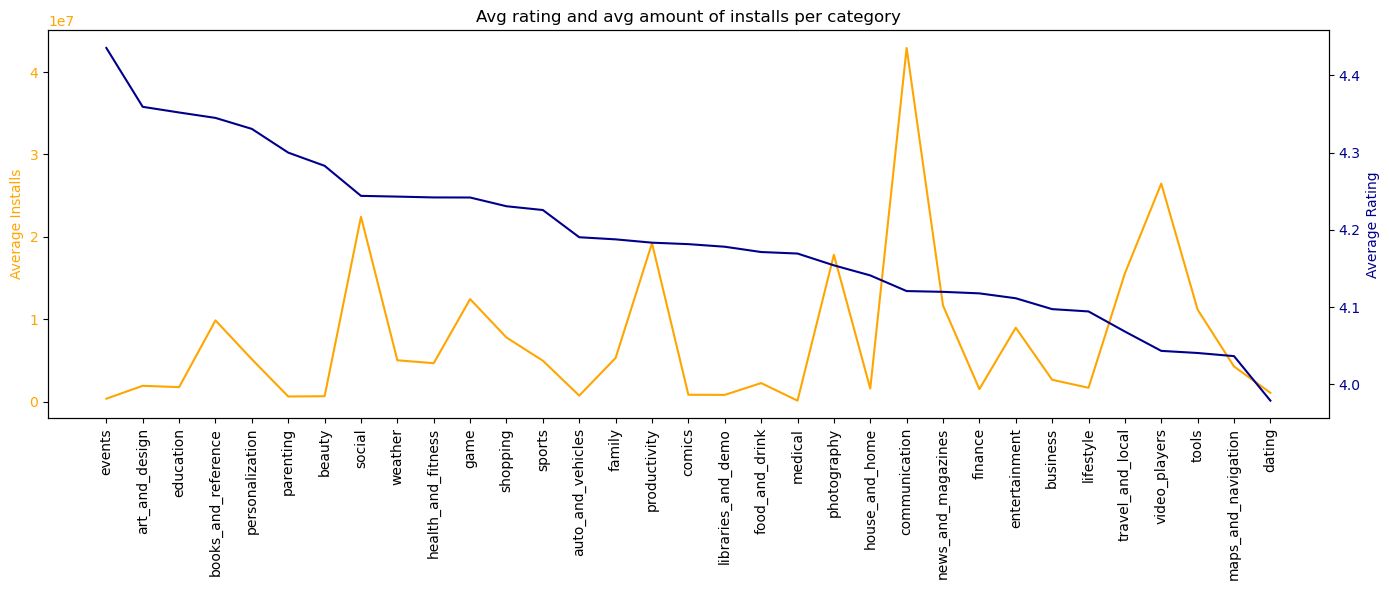

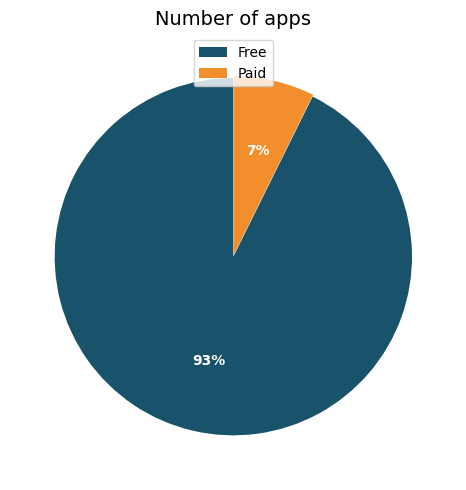

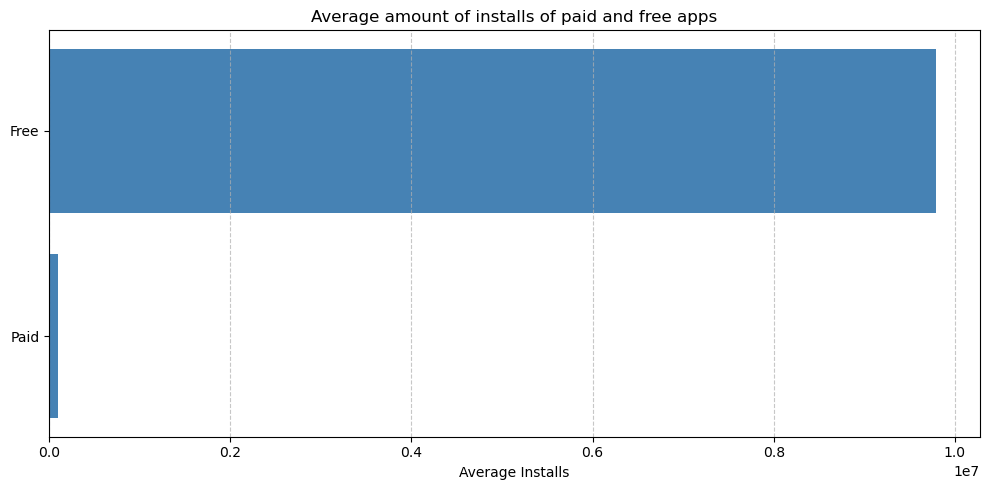

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


df = pd.read_csv('googleplaystore.csv')

df=df.rename(columns={col:col.replace(" ","_").lower()for col in df.columns})

#df = df.rename(columns = {"})
#df.rename(columns ={"App","Reviews": "reviews", "Size": "size", "Installs": "installs,Last Updated" : "last_updated", "Category" : "category" , "Android Ver" : "android_ver"} , inplace= True)

#df.columns


def clean_reviews (df, column):
    df[column] = df[column].str.replace('.0M', '000000', regex=False)
    df[column] = df[column].astype(int)
    return df[column]

df["reviews"] = clean_reviews(df, "reviews")


def clean_installs (df, column):
    df[column] = df[column].str.replace('+', '', regex=False)
    df[column] = df[column].str.replace(',', '', regex=False)
    df[column] = df[column].replace('Free', '1000', regex=False)
    df[column] = df[column].astype(int)
    return df[column]

df["installs"] = clean_installs (df, "installs")


# clean size

df["size"] = df["size"].str.replace(',000+', '', regex=False)
df["size"] = df["size"].replace('Varies with device', '0', regex=False)


def convert_to_kilobytes(size):
    if 'M' in size:
        return float(size.replace('M', ''))
    elif 'k' in size:
        return float(size.replace('k', '')) / 1000
    else:
        return float(size)

df['size'] = df['size'].apply(convert_to_kilobytes)

df["size"] = df["size"].replace(0, round(df["size"].mean(), 3), regex=False)
df["size"] = df["size"].astype(float)
maximum=max(df['size'])
minimum=min(df['size'])


#df = df.dropna(subset=['Rating'])
#df['price'] = df['price'].str.replace('$', '', regex=True)
#df['price'] = df['price'].replace('Free', '0')
#df['price'] = df['price'].astype(float)

df['price'] = df['price'].str.replace('$', '', regex=False)
df['price'] = df['price'].replace('Free', '0').replace('Everyone', '0')
df['price'] = df['price'].astype(float)

df = df[df['rating'] <= 5]
df['content_rating'].fillna(df['content_rating'].mode()[0], inplace=True)

df['last_updated'] = pd.to_datetime(df['last_updated'], errors='coerce')
df['category'] = df['category'].str.upper()


def clean_text_column(df, column_name):
    special_char_pattern = r'[^a-zA-Z0-9\s]'
    df[column_name]=df[column_name].str.lower().str.strip()
    df[column_name]=df[column_name].str.replace('&', 'and', regex=False)
    df[column_name]=df[column_name].str.replace(special_char_pattern, '', regex=True)
    df[column_name] = df[column_name].str.replace(r'\s+', ' ', regex=True)
    df[column_name]=df[column_name].str.capitalize()
    return df
    
    
df = clean_text_column(df, 'app')

df['last_updated'] = pd.to_datetime(df['last_updated'], errors='coerce').dt.strftime('%Y-%m-%d')

def categorize_android_version(version):
    if pd.isna(version) or "Varies" in version:
        return "Missing"

    first_version = version.split(" ")[0].split("-")[0].strip()
    
    try:
        major_version = float(".".join(first_version.split(".")[:2]))
    except:
        return "Missing"
    
    if major_version < 4.0:
        return "3.0"
    elif 4.0 <= major_version < 5.0:
        return "4.0"
    elif 5.0 <= major_version < 6.0:
        return "5.0"
    elif 6.0 <= major_version < 7.0:
        return "6.0"
    elif 7.0 <= major_version < 8.0:
        return "7.0"
    elif major_version >= 8.0:
        return "8.0"
    else:
        return "Missing"

df["android_ver"] = df["android_ver"].apply(categorize_android_version)

df["category"] = df["category"].str.strip().str.lower().replace("1.9", np.nan)

df=df.drop_duplicates()

df = df.drop_duplicates(subset='app', keep='last')

df.to_csv('cleaned_file.csv', index=False,encoding = "utf_8", sep=";")

# Group by category to get average rating and installs
grouped = df.groupby('category').agg(
    average_rating=('rating', 'mean'),
    average_installs=('installs', 'mean')
).dropna().reset_index()

# Sort by average_rating descending (as in your chart)
grouped = grouped.sort_values(by='average_rating', ascending=False)

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot average installs (orange line)
ax1.plot(grouped['category'], grouped['average_installs'], color='orange', label='average_installs')
ax1.set_ylabel('Average Installs', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# Secondary axis for average rating
ax2 = ax1.twinx()
ax2.plot(grouped['category'], grouped['average_rating'], color='darkblue', label='avg_rating')
ax2.set_ylabel('Average Rating', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

# Title and X-axis formatting
plt.title('Avg rating and avg amount of installs per category')
ax1.set_xticks(range(len(grouped['category'])))
ax1.set_xticklabels(grouped['category'], rotation=90)

plt.tight_layout()
plt.show()

# Classify apps as Free or Paid
df['type'] = df['price'].apply(lambda x: 'Free' if x == 0 else 'Paid')

# Count Free vs Paid apps
counts = df['type'].value_counts()

# Plot pie chart
colors = ['#19536B', '#F28E2B']  # Custom colors to match your chart
labels = counts.index
sizes = counts.values
explode = [0.01 if label == 'Paid' else 0 for label in labels]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', explode=explode,
        startangle=90, textprops={'color': 'white', 'weight': 'bold'})
plt.title('Number of apps', fontsize=14)
plt.legend(labels, loc="upper center")
plt.tight_layout()
plt.show()

# Create a DataFrame with average installs
data = {'Type': ['Paid', 'Free'],
        'Average Installs': [95694, 9788392]} 

df = pd.DataFrame(data)

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 5))
plt.barh(df['Type'], df['Average Installs'], color='steelblue')
plt.xlabel('Average Installs')
plt.title('Average amount of installs of paid and free apps')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
